# Semantic Mapping of Mental Health Survey Questions

## 1. Overview

This notebook implements **Method 1 (Baseline): Semantic Mapping** for the mental health dimension reduction project.

The goal of this method is to map diverse mental health survey questions onto a shared set of **high-level wellness dimensions** (Emotional, Social, Physical, Occupational, Intellectual, Spiritual, Environmental, Financial) using a **concept-driven, label-free approach**.

Rather than learning dimension representations from labeled data, this approach begins by defining the *same set of wellness dimension types* using **natural-language definitions generated by multiple large language models (LLMs)**.  
Each LLM is prompted with an identical instruction, producing alternative textual realizations of the same conceptual dimensions.

These model-generated dimension definitions serve as **semantic prototypes (anchors)**. Both survey questions and dimension prototypes are embedded into a shared semantic space using a pretrained sentence encoder. Survey questions are then mapped back to the wellness dimensions by measuring cosine similarity to the corresponding prototypes, allowing each question to be assigned to one or more dimensions.

By holding the dimension types fixed while varying the language used to define them, this method enables controlled comparisons of how different LLM-generated definitions influence semantic alignment and downstream mappings. Semantic mapping thus provides a principled bridge between conceptual wellness frameworks and data-driven analysis.

## 2. Data

Each data point corresponds to a **single survey question**, represented with:
- `qid`: the original item identifier (e.g., PSQI_5_3, PSS_12)
- `dataset`: the source questionnaire or scale
- `text`: the question text

All questions are consolidated into a canonical dataset (`questions_master`) during preprocessing to ensure:
- No modification of raw source files
- Consistent identifiers across methods
- Reproducibility across models and experiments


In [24]:
from utils import load_questions
import pandas as pd
import numpy as np
from pathlib import Path

questions = load_questions()
questions.head()

,qid,dataset,text
0,CD_RISC_1,CD-RISC,I am able to adapt when changes occur.
1,CD_RISC_2,CD-RISC,I have one close and secure relationship.
2,CD_RISC_3,CD-RISC,Sometimes fate or God helps me.
3,CD_RISC_4,CD-RISC,I can deal with whatever comes my way.
4,CD_RISC_5,CD-RISC,Past successes give me confidence.


In [25]:
print("Total questions:", len(questions))
questions["dataset"].value_counts()

Total questions: 145


dataset
PWS        36
CD-RISC    25
PERMA      23
PSS        23
UCLA       20
PWB        18
Name: count, dtype: int64

## 3. Dimension
The wellness dimensions used in this project are represented by natural-language definitions generated by multiple large language models (LLMs).
Each model is prompted using the same fixed instruction, ensuring that differences across dimension sets reflect model-specific generation behavior rather than prompt variation.


- `model_name`: the identifier of the large language model used to generate the definition  
- `dim_name`: the name of the wellness dimension (e.g., Emotional, Social, Physical)  
- `dim_text`: the natural-language definition generated for that dimension
A utility function (`load_dimension_sets`) is provided to load this file and group the definitions by model.  
The resulting data structure is a dictionary mapping each model name to a list of its corresponding dimension definitions, for example:

```python
{
  "ChatGPT-5.2": [
    "Emotional: ...",
    "Environmental: ...",
    "Financial: ...",
    "Intellectual: ...",
    "Occupational: ...",
    "Physical: ...",
    "Social: ...",
    "Spiritual: ..."
  ],
  "DeepSeek-V3.2": [...],
  "Llama-4": [...],
  "claude-sonnet-4.5": [...],
  "gemini-3.0-pro": [...]
}
```
Each model-specific dimension set is used independently as a collection of semantic prototypes.
These prototypes are mapped against the survey questions described in Section 2 (Data), enabling controlled comparisons of how different LLM-generated dimension definitions influence downstream question-to-dimension mappings.

In [26]:
from utils import load_dimension_sets
dimension_sets = load_dimension_sets("./dim_definations.csv")
print(dimension_sets)
print(len(dimension_sets), len(dimension_sets["Llama-4"]))

{'ChatGPT-5.2': ['Emotional: The ability to recognize, understand, express, and manage feelings in ways that support resilience, balance, and healthy responses to life events.', 'Environmental: The quality of interaction with surrounding spaces, resources, and conditions that influence comfort, safety, and daily functioning.', 'Financial: The capacity to manage money decisions and resources in ways that support stability, choice, and future needs.', 'Intellectual: The ongoing engagement with learning, curiosity, creativity, and critical thinking to expand understanding and skills.', 'Occupational: The sense of purpose, satisfaction, and alignment experienced through work or meaningful daily roles.', 'Physical: The state of the body and the habits that support energy, strength, mobility, and overall functioning.', 'Social: The ability to build, maintain, and experience supportive relationships and a sense of belonging.', 'Spiritual: The way meaning, values, and connection guide a person

## 4. Semantic Mapping Using LLM-Generated Dimensions

In this stage, we perform semantic mapping between survey questions and
wellness dimensions using the `SemanticMapper` module
(`model/mapping/semantic_mapper.py`).

### Mapping Procedure

For each set of dimension definitions generated by a large language model (LLM),
we independently perform a full semantic mapping process.
This results in **one mapping output per LLM**, allowing us to compare
consistency and variation across models.

The mapping procedure consists of the following steps:

1. **Encoding**
   - Survey questions and wellness dimension definitions are embedded into a
     shared semantic space using a pretrained sentence embedding model
     (`all-MiniLM-L6-v2`).
   - The same encoder is used for both questions and dimensions to ensure
     comparability.

2. **Similarity Computation**
   - For each question, cosine similarity is computed against all dimension
     embeddings, producing a question–dimension similarity matrix.

3. **Margin-Based Assignment**
   - Each question is first assigned to the dimension with the highest
     similarity score.
   - Additional dimensions are included if their similarity scores fall within
     a predefined margin (`delta`) of the top score.
   - This allows a single question to be assigned to **multiple dimensions**
     when semantic overlap exists, reflecting the multifaceted nature of
     mental health constructs.

## Output Structure

Each mapping run produces a table (CSV) where **each row corresponds to one survey question mapped under one LLM-generated dimension set**. Conceptually, each row has the following structure:

```python
{
  "qid": "CD_RISC_1",
  "dataset": "CD-RISC",
  "text": "I am able to adapt when changes occur.",
  "dimension_model": "ChatGPT-5.2",
  "dimensions": ["Emotional", "Spiritual", "Physical"],
  "scores": [0.18, 0.17, 0.16]
}
```
- **`qid`**  
  Unique identifier of the survey question.

- **`dataset`**  
  Source questionnaire (e.g., CD-RISC, PERMA, PSS, UCLA).

- **`text`**  
  Original survey question text.

- **`dimension_model`**  
  The LLM used to generate the wellness dimension definitions for this run.

- **`dimensions`**  
  One or more assigned wellness dimensions.  
  Multiple dimensions may be selected when their similarity scores fall within a margin (Δ) of the best match.

- **`scores`**  
  Cosine similarity scores corresponding to the listed dimensions (same order).


In [27]:
from semantic_mapper import SemanticMapper
DELTA = 0.05
mapper = SemanticMapper(model="all-MiniLM-L6-v2")
mapper.set_questions_df(questions)
all_results = {}

for model_name, dim_list in dimension_sets.items():
    mapper.set_dimensions(
        dim_list,
        dimension_model_name=model_name
    )
    df_map = mapper.map_questions_to_dimensions(delta=DELTA)
    all_results[model_name] = df_map
    mapper.save_mapping_to_csv(df_map, delta=DELTA, out_dir=Path("./temp_result"))


## 4. Analysis: Cross-Model Agreement Using Pairwise Jaccard Similarity

To evaluate whether semantic mappings are stable across different LLM-generated dimension definitions, we compare the dimension assignments produced by five independent definition sets. Each set is generated by a different large language model (LLM), while the embedding model, similarity metric, and decision rule remain fixed.

Rather than requiring full agreement across all models, we focus on **pairwise agreement**, which better reflects whether the resulting mappings are *broadly comparable* across different definition sets.

### Pairwise Jaccard Similarity

For a given survey question, let $$D_i$$ and $$D_j$$ denote the sets of dimensions assigned by two different LLM-generated definition sets. The Jaccard similarity between the two assignments is defined as:

$$
J(D_i, D_j)
=
\frac{|D_i \cap D_j|}{|D_i \cup D_j|}
$$

We compute this score for all unordered pairs of models and report the **mean pairwise Jaccard similarity**:

$$
\bar{J}
=
\frac{2}{K(K-1)}
\sum_{i<j}
\frac{|D_i \cap D_j|}{|D_i \cup D_j|}
$$

where $$K = 5$$ is the number of LLMs, resulting in $$\binom{5}{2} = 10$$ model pairs per question.

This average score captures how similar the dimension assignments are *on average* across models, without requiring strict unanimity.

### Example

Consider a survey question mapped by five different LLM-generated dimension sets:

- Model 1: {Emotional, Social}  
- Model 2: {Emotional, Social}  
- Model 3: {Emotional, Social}  
- Model 4: {Emotional}  
- Model 5: {Emotional}  

Among the 10 model pairs:
- 4 pairs compare identical sets {Emotional, Social}, yielding $$J = 1.0$$
- 6 pairs compare {Emotional, Social} with {Emotional}, yielding $$J = 0.5$$

The mean pairwise Jaccard similarity is therefore:

$$
\bar{J}
=
\frac{4 \times 1.0 + 6 \times 0.5}{10}
=
0.75
$$

A value of $$\bar{J} = 0.75$$ indicates that, on average, any two models share most of their assigned dimensions for this question. This reflects **strong overall agreement**, with disagreements limited to secondary dimensions rather than the core interpretation.

In [28]:
print(all_results.keys())
for model_name, df_map in all_results.items():
    print(f"\n=== Model: {model_name} ===")
    print(df_map.iloc[0].to_dict())
    break


dict_keys(['ChatGPT-5.2', 'DeepSeek-V3.2', 'Llama-4', 'claude-sonnet-4.5', 'gemini-3.0-pro'])

=== Model: ChatGPT-5.2 ===
{'qid': 'CD_RISC_1', 'dataset': 'CD-RISC', 'text': 'I am able to adapt when changes occur.', 'dimension_model': 'ChatGPT-5.2', 'dimensions': ['Emotional', 'Spiritual', 'Physical', 'Intellectual', 'Occupational', 'Social'], 'scores': [0.1836039274930954, 0.17746786773204803, 0.17690694332122803, 0.16240713000297546, 0.14813588559627533, 0.14609646797180176]}


In [29]:
from utils import compute_cross_model_agreement

agreement_df = compute_cross_model_agreement(all_results)
print(agreement_df.keys())
print(agreement_df.iloc[0].to_dict())
print(len(agreement_df))
agreement_df.to_csv("../../results/mapping/v2_5LLM_aggrement.csv", index=False)

Index(['qid', 'dataset', 'text', 'mean_pairwise_jaccard', 'union_dimensions',
       'consensus_dimensions'],
      dtype='str')
{'qid': 'CD_RISC_1', 'dataset': 'CD-RISC', 'text': 'I am able to adapt when changes occur.', 'mean_pairwise_jaccard': 0.5833333333333333, 'union_dimensions': ['Emotional', 'Intellectual', 'Occupational', 'Physical', 'Social', 'Spiritual'], 'consensus_dimensions': ['Emotional', 'Intellectual', 'Occupational', 'Spiritual']}
145


<Figure size 800x400 with 0 Axes>

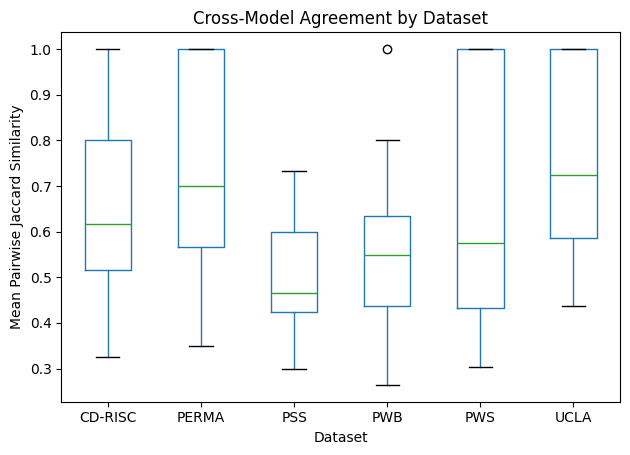

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))

agreement_df.boxplot(
    column="mean_pairwise_jaccard",
    by="dataset",
    grid=False
)

plt.suptitle("") 
plt.title("Cross-Model Agreement by Dataset")
plt.xlabel("Dataset")
plt.ylabel("Mean Pairwise Jaccard Similarity")

plt.tight_layout()
plt.show()

## 5. High-Confidence Dimension Assignments (Strict Consensus)

While Section 4 demonstrates that dimension assignments are broadly comparable across different LLM-generated definitions, certain questions exhibit partial disagreement due to sensitivity to definition phrasing. To obtain a set of **maximally reliable and interpretable labels**, we introduce a stricter, dimension-wise consensus criterion in this section.

For a given survey question \( q \), let \( D_i(q) \) denote the set of wellness dimensions assigned under the \( i \)-th LLM-generated definition set.  
A dimension \( d \) is considered **high-confidence** for question \( q \) if and only if:

$$
d \in \bigcap_{i=1}^{5} D_i(q)
$$

Only dimensions that appear in the assignments of **all five** LLMs are retained. Questions for which this intersection is empty are excluded from the high-confidence subset.

In [31]:
from utils import compute_consensus_spectrum
high_conf_df = compute_consensus_spectrum(all_results)
print(high_conf_df.keys())
print(high_conf_df.iloc[0].to_dict())
print(len(high_conf_df))
high_conf_df.to_csv("../../results/mapping/v2_5LLM_confidence_agreement.csv", index=False)

Index(['qid', 'dataset', 'text', 'exact_5of5', 'exact_4of5', 'exact_3of5',
       'exact_2of5', 'exact_1of5'],
      dtype='str')
{'qid': 'CD_RISC_1', 'dataset': 'CD-RISC', 'text': 'I am able to adapt when changes occur.', 'exact_5of5': ['Emotional', 'Intellectual'], 'exact_4of5': [], 'exact_3of5': ['Occupational', 'Spiritual'], 'exact_2of5': [], 'exact_1of5': ['Physical', 'Social']}
145


In [32]:
def highest_consensus_level(row, K=5):
    for k in range(K, 0, -1):
        if len(row[f'exact_{k}of{K}']) > 0:
            return k
    return 0

high_conf_df['max_consensus'] = high_conf_df.apply(
    highest_consensus_level, axis=1
)

level_counts = (
    high_conf_df['max_consensus']
    .value_counts()
    .sort_index(ascending=False)
    .reset_index()
)
level_counts.columns = ['consensus_level', 'num_questions']
level_counts['percentage'] = level_counts['num_questions'] / len(high_conf_df)

level_counts

,consensus_level,num_questions,percentage
0,5,114,0.786207
1,4,31,0.213793


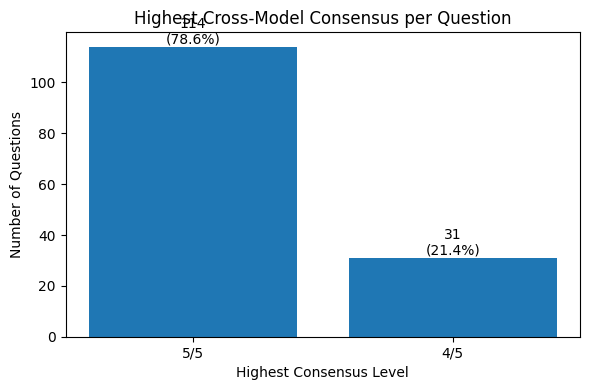

In [33]:
import matplotlib.pyplot as plt

# level_counts already computed
# columns: ['consensus_level', 'num_questions', 'percentage']

# Convert to string labels like "5/5"
level_counts['label'] = level_counts['consensus_level'].astype(str) + '/5'

plt.figure(figsize=(6,4))
bars = plt.bar(
    level_counts['label'],
    level_counts['num_questions']
)

plt.ylabel('Number of Questions')
plt.xlabel('Highest Consensus Level')
plt.title('Highest Cross-Model Consensus per Question')

# Annotate bars with count + percentage
for bar, pct in zip(bars, level_counts['percentage']):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{int(height)}\n({pct:.1%})',
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.show()